## Training a Keras model to generate colours

apply RNn to process character sequences

In [1]:
# https://heartbeat.comet.ml/how-to-train-a-keras-model-to-generate-colors-3bc79e54971b

There are two general options for language modeling: word-level models and character-level models. Each has its advantages and disadvantages. Let’s go through them now

### Word-level Language Model
The word-level language model can handle relatively long and clean sentences. By “clean”, I mean the words in the text datasets are free from typos and have few words outside of English vocabulary. The word-level language model encodes each unique word into a corresponding integer, and there’s a predefined fixed-sized vocabulary dictionary to look up the word to integer mapping. One major benefit of the word-level language model is its ability to leverage pre-trained word embeddings such as Word2Vec or GloVe. These embeddings represent words as vectors with useful properties. Words close in context are close in Euclidean distance and can be used to understand analogies like "man is to women, as king is to queen". Using these ideas, you can train a word-level model with relatively small labeled training sets

### Character Level Language Model
But there’s an even simpler language model, one that splits a text string into characters and associates a unique integer to every single character. There are some reasons you might choose to use the character-level language model over the more popular word-level model:

* Your text datasets contain a noticeable amount of out-of-vocabulary words or infrequent words. In our case, some legitimate color names could be “aquatone”, “chartreuse” and “fuchsia”. For me, I have to check a dictionary to find out their meanings, and traditional word-level embeddings may not contain them.
* The majority of the text strings are short, bounded-length strings. If you’re looking for a specific length limit, I’ve been dealing with a Yelp review generation model with character level encode character length of 60 and still get decent results. You can find that blog post here: How to generate realistic yelp restaurant reviews with Keras. Usually, the character-level language generation model can create text with more variety since its imagination is not constrained by a pre-defined dictionary of vocabulary.
You may also be aware of the limitation that came with adopting character-level language: - Long sequences may not capture long-range dependencies as well as word-level language models. - Character-level models are also more computationally expensive to train — given the same text data sets, these model sequences are longer and, as a result, require extended training time.

Fortunately, these limitations won’t pose a threat to our color generation task. We’re limiting our color names to 25 characters in length and we only have 18,606 training samples.

In [2]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Reshape

import numpy as np
import pandas as pd

In [4]:
# Now, we can load the data into a Pandas data-frame and create separate series with color names.

data = pd.read_csv("data/colors.csv")
names = data["name"]
data.head()

,name,red,green,blue
0,18th Century Green,165,147,68
1,1975 Earth Red,123,70,59
2,1989 Miami Hotline,221,51,102
3,20000 Leagues Under the Sea,25,25,112
4,3AM in Shibuya,34,85,119


In [11]:
data.shape

(18606, 4)

### Data Preparation
We mentioned that we’re limiting our color names to 25 characters. To arrive at this number, we checked the distribution of the length of color names across all training samples and visualize it to make sure the length limit we pick makes sense.

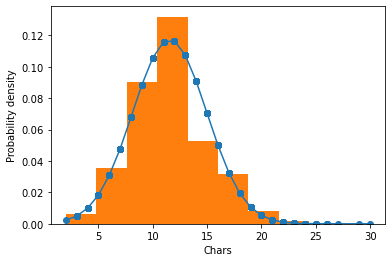

In [9]:
h = sorted(names.str.len().values)
import numpy as np
import scipy.stats as stats
import pylab as plt

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
plt.plot(h,fit,'-o')
plt.hist(h, density=True, stacked=True)      #use this to draw histogram of your data
plt.xlabel('Chars')
plt.ylabel('Probability density')
plt.show()

In [10]:
# See majority have strings <25, max length 30.  Could choose 30, but would need to be trained for longer.  
# Transform string to list 25 integer values with text tokenization utility

maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
print(padded_names.shape)

# If a string has less than 25 characters, it will be padded with the value 0 from the beginning of the sequence.

(18606, 25)


### One-hot Encoding
We can view the character to integer mapping by inspecting the t.word_index property of the instance of Keras’ Tokenizer.



In [12]:
print(t.word_index)

{'e': 1, 'a': 2, ' ': 3, 'r': 4, 'i': 5, 'l': 6, 'n': 7, 'o': 8, 's': 9, 't': 10, 'c': 11, 'u': 12, 'd': 13, 'g': 14, 'p': 15, 'h': 16, 'b': 17, 'm': 18, 'y': 19, 'w': 20, 'k': 21, 'f': 22, 'v': 23, 'z': 24, 'j': 25, 'q': 26, 'x': 27, "'": 28, '-': 29, 'ō': 30, 'è': 31, 'é': 32, 'ā': 33, 'á': 34, 'ó': 35, 'ū': 36, '0': 37, '8': 38, '.': 39, 'ē': 40, 'ī': 41, 'ǎ': 42, '!': 43, 'í': 44, '&': 45, 'ǜ': 46, '9': 47, '2': 48, 'à': 49, 'ǐ': 50, '’': 51, '6': 52, 'ú': 53, '1': 54, '3': 55, 'â': 56, '4': 57, 'ǔ': 58, 'ì': 59, '7': 60, '5': 61, 'ê': 62, 'ö': 63, 'ł': 64, 'š': 65, 'ü': 66, '₂': 67, 'ò': 68, 'ñ': 69, 'ě': 70, 'ń': 71, 'ä': 72, 'œ': 73, 'ß': 74, '%': 75, 'ı': 76, 'ż': 77, '/': 78, 'î': 79, 'ë': 80, '(': 81, ')': 82, 'å': 83, '$': 84, 'я': 85, 'ő': 86, 'ğ': 87, 'ç': 88, 'ù': 89}


We can see that all of the most frequent characters (letters) are in the top 25. Therefore, this number should be sufficient.

However, the integer values have no natural ordered relationship between each other and our model may not be able to harness any benefit from it. What’s worse, our model will initially assume such an ordering relationship among those characters (i.e. “a” is 2 and “e” is 1 but that should not signify a relationship), which can lead to an unwanted result. We will use one-hot encoding to represent the input sequence.

Each integer will be represented by a boolean array where only one element in the array will have a value of 1. The max integer value will determine the length of the boolean array in the character dictionary.

In our case, the max integer value is 'ù': 89, so the length of a one-hot boolean array will be 90 (considering the lowest value starts with 0, which is the padding).

For example, instead of using the integer value 2 to represent character ‘a’, we’re going to use one-hot array [0, 0, 1, 0 …….. 0].

One-hot encoding is also accessible in Keras.



In [14]:
from tensorflow.python.keras.utils import np_utils
one_hot_names = np_utils.to_categorical(padded_names)
one_hot_names.shape

(18606, 25, 90)

The resulting one-hot-names has the shape (18606, 25, 90), which stands for (# of training samples, max sequence length, # of unique tokens).
### Data Normalization
Remember we’re predicting 3 color channel values, each value ranging between 0–255. There is no golden rule for data normalization. Data normalization is purely practical because in practice it could take a model forever to converge if the training data values are spread out too much. A common normalization technique is to scale values to [-1, 1]. In our model, we’re using a ReLu activation function in the last layer. Since ReLu outputs non-negative numbers, we’ll normalize the values to [0, 1].

In [15]:
# The RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data["red"]), norm(data["green"]), norm(data["blue"])])

In [16]:
normalized_values

array([[0.64705882, 0.57647059, 0.26666667],
       [0.48235294, 0.2745098 , 0.23137255],
       [0.86666667, 0.2       , 0.4       ],
       ...,
       [0.80392157, 0.83529412, 0.83529412],
       [0.        , 0.5372549 , 0.58823529],
       [0.14117647, 0.54509804, 0.8       ]])

### Building the Model
To build our model we’re going to use two types of neural networks: a feed-forward neural network and a recurrent neural network. The feed-forward neural network is by far the most common type of neural network. In this neural network, the information comes into the input units and flows in one direction through hidden layers until each reaches the output units.

In recurrent neural networks, information can flow around in cycles. These networks can remember information for a long time. Recurrent networks are a very natural way to model sequential data. In our specific model, we’re using one of the most powerful recurrent networks named long short term memory (LSTM).

The easiest way to build a deep learning model in Keras is to use its sequential API, and we simply connect each of the neural network layers by calling its model.add() function like connecting LEGO bricks.



In [17]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, 90)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

2021-11-03 23:44:11.861225: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# training a model by calling model.fit() function cannot be any easier
history = model.fit(one_hot_names, normalized_values,
                    epochs=40,
                    batch_size=32,
                    validation_split=0.2)

2021-11-03 23:44:41.671820: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
466/466 [==============================] - 61s 124ms/step - loss: 0.0685 - acc: 0.5818 - val_loss: 0.0631 - val_acc: 0.6279
Epoch 2/40
466/466 [==============================] - 61s 131ms/step - loss: 0.0643 - acc: 0.6198 - val_loss: 0.0607 - val_acc: 0.6139
Epoch 3/40
466/466 [==============================] - 67s 144ms/step - loss: 0.0615 - acc: 0.6325 - val_loss: 0.0600 - val_acc: 0.6274
Epoch 4/40
466/466 [==============================] - 68s 146ms/step - loss: 0.0592 - acc: 0.6322 - val_loss: 0.0583 - val_acc: 0.6018
Epoch 5/40
466/466 [==============================] - 67s 143ms/step - loss: 0.0568 - acc: 0.6369 - val_loss: 0.0579 - val_acc: 0.6061
Epoch 6/40
466/466 [==============================] - 75s 161ms/step - loss: 0.0546 - acc: 0.6406 - val_loss: 0.0563 - val_acc: 0.6136
Epoch 7/40
466/466 [==============================] - 75s 160ms/step - loss: 0.0525 - acc: 0.6402 - val_loss: 0.0554 - val_acc: 0.6051
Epoch 8/40
466/466 [==============================] - 6

### Generate Colors
Let’s define some functions to generate and show the color predicted.

For a color name input, we need to transform it into the same one-hot representation. To achieve this, we tokenize characters to integers with the same tokenizer with which we processed the training data, pad it to the max sequence length of 25, then apply the one-hot encoding to the integer sequence.

And for the output RGB values, we need to scale it back to 0–255, so we can display them correctly.

In [19]:
# plot a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

def scale(n):
    return int(n * 255) 

def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=90)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

forest, R,G,B: 29 81 25


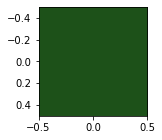

ocean, R,G,B: 23 82 145


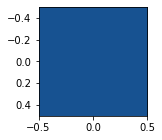

In [20]:
# Let’s give the predict() function a try.

predict("forest")
predict("ocean")

Conclusion

In this post, we talked about how to build a Keras model that can take any color name and come up with an RGB color value. More specifically, we looked at how to apply the one-hot encoding to character-level language models, building a neural network model with a feed-forward neural network and recurrent neural network.

Here’s a diagram to summarize what we have built in the post, starting from the bottom and showing every step of the data flow.